In [3]:
############### Imports ###############
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge 


from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn_pandas import DataFrameMapper


In [4]:
############### Data ###############
df1 = pd.read_csv("/Users/biancaorozco/Desktop/Metis/week02/project-02/airfare_project2/data/expedia_10_8_2019.csv")
df2 = pd.read_csv("/Users/biancaorozco/Desktop/Metis/week02/project-02/airfare_project2/data/expedia_10_9_2019.csv")
df3 = pd.read_csv("/Users/biancaorozco/Desktop/Metis/week02/project-02/airfare_project2/data/expedia_10_10_2019.csv")

frames = [df1, df2, df3]
na_df = pd.concat(frames)
print(na_df.shape)
na_df.sample(15, random_state=40)

(3183, 10)


/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


,airline,arrival_airport,arrival_time,date,departure_airport,departure_time,duration,id_flight,number_stops,prices
168,American Airlines,San Francisco SFO,7:11pm,10/9/2019,Atlanta ATL,3:20pm,4h 51m,13.0,(1 stop),$376
1237,United,San Francisco SFO,9:31am,10/8/19,Seattle SEA,7:18am,2h 13m,11.0,(Nonstop),$336
711,United,Los Angeles LAX,7:40pm,10/9/2019,Dallas DFW,2:15pm,6h 25m,25.0,(1 stop),$379
2,JetBlue Airways,New York JFK,1:10pm,10/8/19,Atlanta ATL,10:56am,2h 14m,2.0,(Nonstop),$294
1172,United,Denver DEN,12:06pm,10/8/19,Chicago ORD,10:15am,2h 51m,16.0,(Nonstop),$414
246,United,Chicago ORD,7:43pm,10/10/2019,Los Angeles LAX,10:45am,6h 58m,1.0,(Nonstop),$137
578,American Airlines,Chicago ORD,2:16pm,10/10/2019,Atlanta ATL,9:08am,6h 8m,25.0,(1 stop),$292
158,American Airlines,Dallas DFW,12:31am,10/8/19,Chicago ORD,10:09pm,2h 22m,3.0,(Nonstop),$399
671,Delta,Chicago ORD,5:52pm,10/8/19,New York JFK,8:05am,2h 53m,32.0,(Nonstop),$269
371,United,Dallas DFW,1:18pm,10/8/19,Denver DEN,5:30am,6h 48m,41.0,(1 stop),$379


In [5]:
############### Functions ###############
## Duration Time to Minutes
def duration_to_min(duration):
    time = duration.split()
    try:
        minutes = int(time[0])*60 + int(time[1])
        return minutes
    except:
        return None

## 12-hr Time to Minutes
def time_to_min(times):
    ztime = times.zfill(7)
    spaced_time = ztime[:5] + ' ' + ztime[5:]
    split = spaced_time.split()
    try:
        if split[2] == 'pm':
            minutes = (int(split[0])+12)*60 + int(split[1])
        else:
            minutes = int(split[0])*60 + int(split[1])
        return minutes
    except:
        return spaced_time

In [6]:
############### Cleaning Data ###############
## Dropping rows with NaNs
na_df.isna().sum()
df = na_df.dropna()
df.isna().sum()

airline              0
arrival_airport      0
arrival_time         0
date                 0
departure_airport    0
departure_time       0
duration             0
id_flight            0
number_stops         0
prices               0
dtype: int64

In [7]:
df['id_flight'] = pd.to_numeric(df.id_flight, downcast='signed')

# ## Replacing Number of Stops
# df['number_stops'].replace('(Nonstop)', value=int('0'), regex=True, inplace=True)
# df['number_stops'].replace('(1 stop)', value=int('1'), regex=True, inplace=True)
# df['number_stops'].replace('(2 stop)', value=int('2'), regex=True, inplace=True)
# df['number_stops'].replace('(3 stop)', value=int('3'), regex=True, inplace=True)
            
## Removing $ and , from Prices and Convert to Numeric
df['prices'].replace('\$', value='', regex=True, inplace=True)
df['prices'].replace(',', value='', regex=True, inplace=True)
df['prices'] = pd.to_numeric(df.prices)

## Removing h & m from Duration Times
df['duration'].replace('h', value='', regex=True, inplace=True)
df['duration'].replace('m', value='', regex=True, inplace=True)

## Replacing : with _ in Departure and Arrival Times
df['departure_time'].replace(':', value=' ', regex=True, inplace=True)
df['arrival_time'].replace(':', value=' ', regex=True, inplace=True)

## Executing Cleaning Functions
df['departure_time'] = df['departure_time'].apply(time_to_min)
df['arrival_time'] = df['arrival_time'].apply(time_to_min)
df['duration'] = df['duration'].apply(duration_to_min)

/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/Users/biancaorozco/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [8]:
df.head()

,airline,arrival_airport,arrival_time,date,departure_airport,departure_time,duration,id_flight,number_stops,prices
0,Delta,New York JFK,780,10/8/19,Atlanta ATL,650,130,0,(Nonstop),294
1,Delta,New York JFK,638,10/8/19,Atlanta ATL,506,132,1,(Nonstop),294
2,JetBlue Airways,New York JFK,790,10/8/19,Atlanta ATL,656,134,2,(Nonstop),294
3,Delta,New York JFK,1419,10/8/19,Atlanta ATL,1285,134,3,(Nonstop),294
4,Delta,New York JFK,879,10/8/19,Atlanta ATL,1460,139,4,(Nonstop),294


In [9]:
print(df['airline'].nunique(), 'airlines') # 10 airlines
print(df['departure_airport'].nunique(), 'departure airports')
print(df['arrival_airport'].nunique(), 'arrival airports')

10 airlines
8 departure airports
7 arrival airports


0    5.68358
1    5.68358
2    5.68358
3    5.68358
4    5.68358
Name: prices, dtype: float64


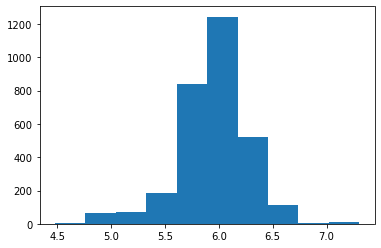

In [10]:
############### Features ###############
X = df.loc[:,['departure_time', 'arrival_time', 'airline', 'duration', 'number_stops', 'departure_airport', 'arrival_airport', 'date']]
y = df['prices']

## Prices are skewed left so take log to transform into a Gaussian Dist.
log_y = np.log(y)
plt.hist(log_y);
print(log_y.head())

In [11]:
############### 2.Dummy Variables ###############
## Dummy Variables for Airlines, Departure Airport, Arrival Airport, and Date
print(X['airline'].nunique(), 'airlines') # 10 airlines
print(X['departure_airport'].nunique(), 'departure airports')
print(X['arrival_airport'].nunique(), 'arrival airports')
print(X['number_stops'].nunique(), 'number of stops\n')
X = pd.get_dummies(X)
X.info()

10 airlines
8 departure airports
7 arrival airports
4 number of stops

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3064 entries, 0 to 897
Data columns (total 35 columns):
departure_time                         3064 non-null int64
arrival_time                           3064 non-null int64
duration                               3064 non-null int64
airline_Alaska Airlines                3064 non-null uint8
airline_American Airlines              3064 non-null uint8
airline_Boutique Air                   3064 non-null uint8
airline_Delta                          3064 non-null uint8
airline_Frontier Airlines              3064 non-null uint8
airline_JetBlue Airways                3064 non-null uint8
airline_Multiple Airlines              3064 non-null uint8
airline_Spirit Airlines                3064 non-null uint8
airline_Sun Country Airlines           3064 non-null uint8
airline_United                         3064 non-null uint8
number_stops_(1 stop)                  3064 non-null uin

In [12]:
############### 3.Split Data ###############
## Splitting Train, Validate, Test Rows
X, X_test, log_y, y_test = train_test_split(X, log_y, test_size=.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, log_y, test_size=.25, random_state=33)

In [13]:
############### Scaling & Modeling ###############
# Model 1
lm = LinearRegression()

# Feature Scaling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

# Model 2
lm_reg = Ridge(alpha=1)

# Feature Transform
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

In [14]:
############### Scores ###############
lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.496
Ridge Regression val R^2: 0.496
Degree 2 polynomial regression val R^2: -3129200506363.189


In [15]:
lm.fit(X,log_y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.438


In [17]:
lm = LinearRegression()
lm.fit(X_train, y_train)
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)
print("R-squared Test:", lm.score(X_test, y_test))
print("R-squared Train:", lm.score(X_train, y_train))

R-squared Test: 0.43788773360406497
R-squared Train: 0.4881947056298791


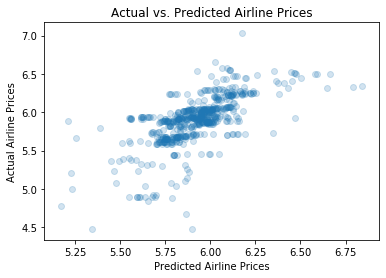

In [24]:
############### Actual vs Predicted ###############
plt.scatter(pred_test, y_test, alpha=.2)
# plt.plot(np.linspace(4,8,1), np.linspace(4,8,1))
plt.title('Actual vs. Predicted Airline Prices')
plt.xlabel('Predicted Airline Prices')
plt.ylabel('Actual Airline Prices');